In [10]:
using PyPlot
using JuMP, Ipopt

In [11]:
include("../src/model.jl");
include("../src/ensemble.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");

In [25]:
dt = 1.
t = Array(2020:dt:2200);

ECS=3.0

GWP = 100. # global world product (trillion $ / year)

β = 0.02*GWP/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.025 # ρ (relative low value from Stern review)

# Control technology cost scales (for full deployment, α=1.)
reduce_cost = 0.01*GWP;
remove_cost = 0.02*GWP;
geoeng_cost = 0.05*GWP;
adapt_cost = 0.03*GWP;

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0.,
    baseline_emissions(t, 5., 2080., 20.)
)

Economics(0.2222222222222222, 0.025, 1.0, 2.0, 5.0, 3.0, 0.0, 0.0, 0.0, 0.0, [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [26]:
ensemble = Dict{String, ClimateModel}();

name = "2020";
controls = init_zero_controls(t);
present_year = 2020.

model = ClimateModel(name, ECS, t, dt, controls, economics, present_year);

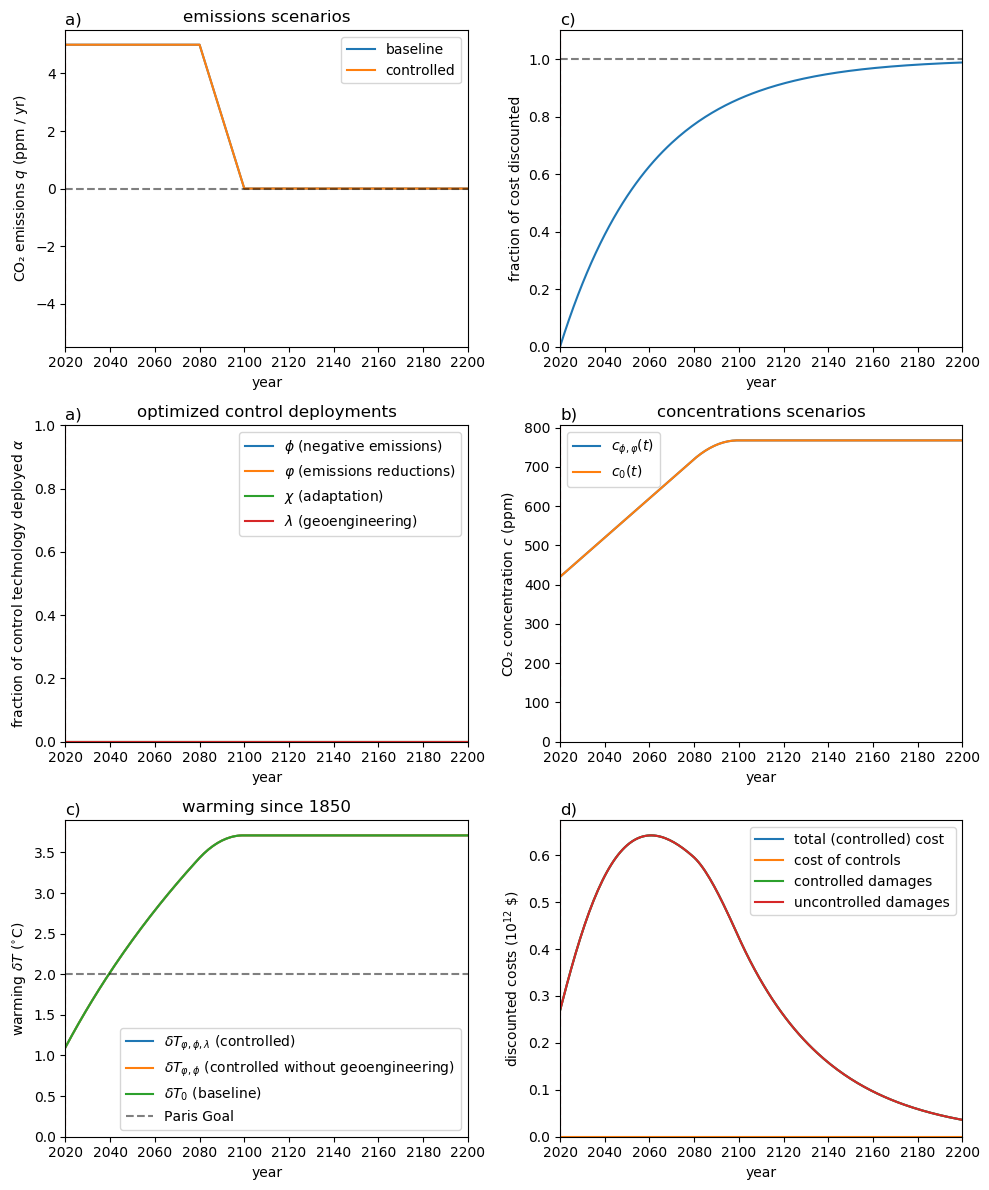

In [27]:
plot_state(model)

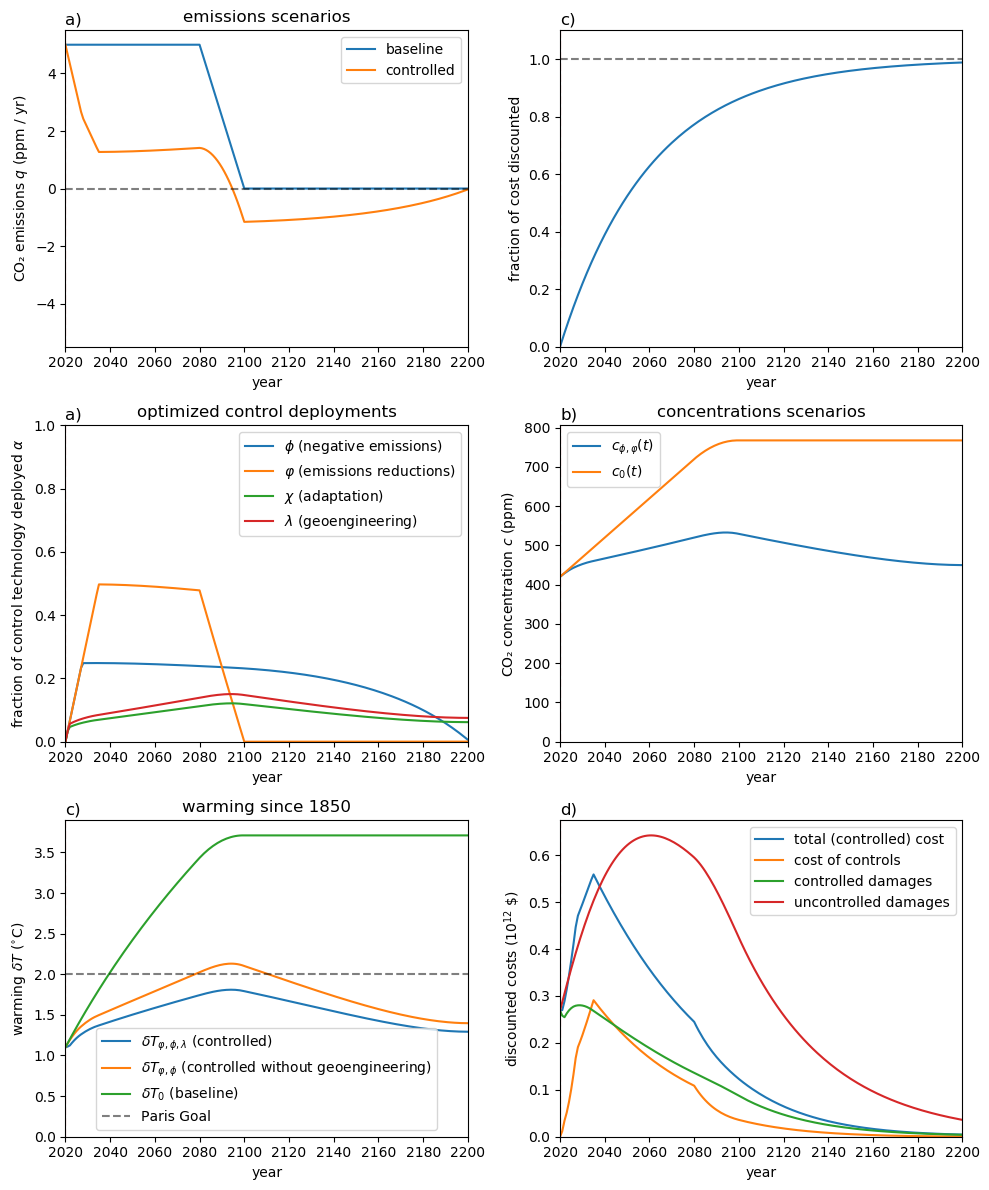

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2776
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1981

Total number of variables............................:     1621
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1440
                     variables with only upper bounds:        0
Total number of equality constraints.................:      901
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [28]:
maxslope = 1. /30.
optimize_controls!(model, maxslope = maxslope);
ensemble[model.name] = model;
plot_state(model)

In [29]:
function step_forward(model::ClimateModel, Δt::Float64, q0::Float64, t0::Float64, Δt0::Float64)

    present_year = deepcopy(model.present_year) + Δt
    present_idx = deepcopy(argmin(abs.(model.domain .- present_year)))
    name = string(Int64(round(present_year)));
    
    controls = Controls(
        deepcopy(model.controls.reduce),
        deepcopy(model.controls.remove),
        deepcopy(model.controls.geoeng),
        deepcopy(model.controls.adapt)
    )
    
    new_emissions = zeros(size(model.domain))
    new_emissions[model.domain .< model.present_year] = deepcopy(model.economics.baseline_emissions)[model.domain .< model.present_year]
    new_emissions[model.domain .>= model.present_year] = deepcopy(baseline_emissions(model.domain, q0, t0, Δt0))[model.domain .>= model.present_year]
    
    economics = Economics(
        β, utility_discount_rate,
        reduce_cost, remove_cost, geoeng_cost, adapt_cost,
        0., 0., 0., 0.,
        new_emissions
    )
    model = ClimateModel(
        model.name, model.ECS, model.domain, model.dt, controls, economics, present_year,
    );
    return model
end

step_forward(model::ClimateModel, Δt::Float64, q0::Float64) = step_forward(model::ClimateModel, Δt::Float64, q0::Float64, 2060., 40.)
step_forward(model::ClimateModel, Δt::Float64) = step_forward(model::ClimateModel, Δt::Float64, 5., 2060., 40.)

step_forward (generic function with 3 methods)

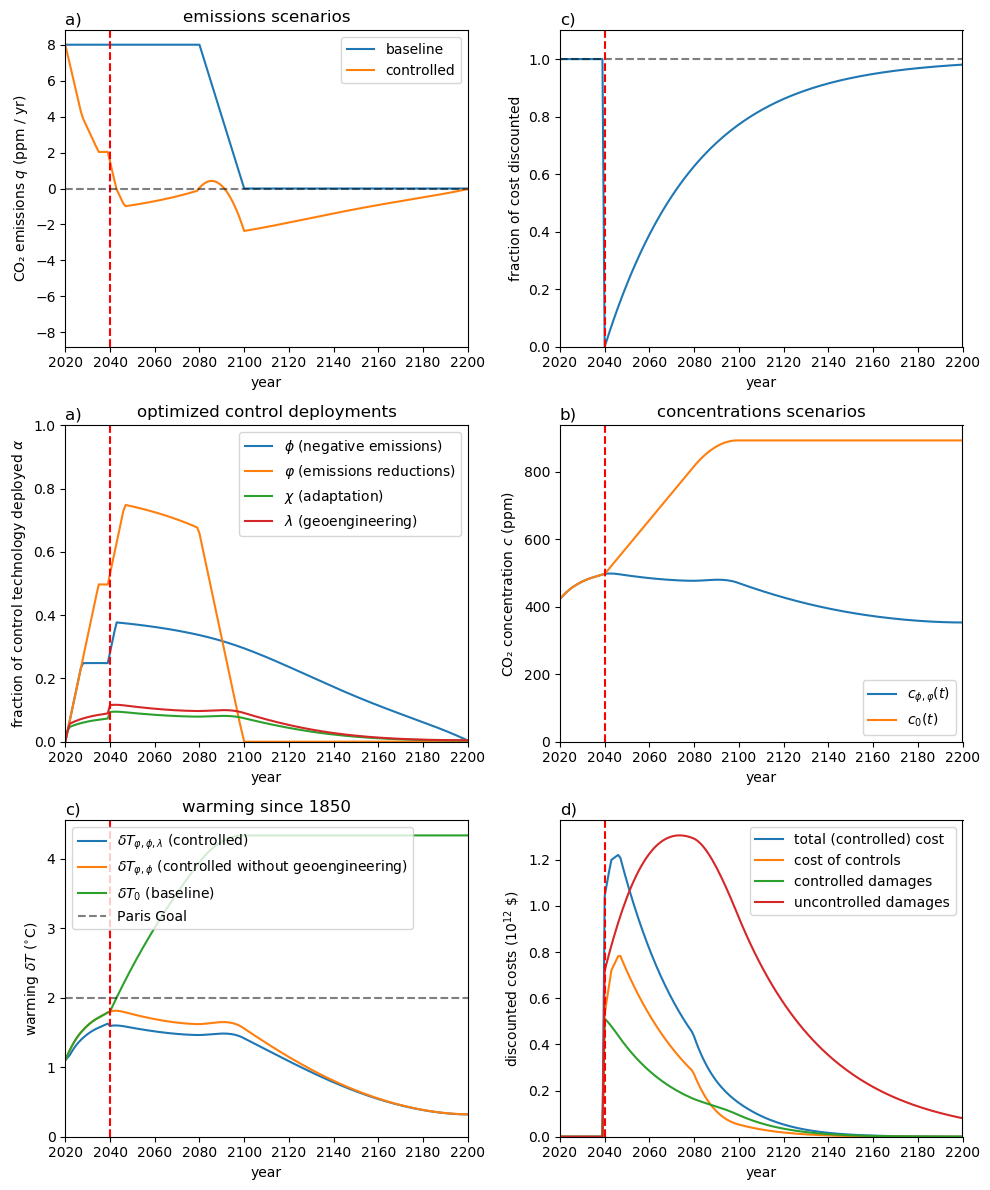

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2586
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1810

Total number of variables............................:     1545
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1364
                     variables with only upper bounds:        0
Total number of equality constraints.................:      901
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [30]:
model = step_forward(model, 20., 8., 2080., 20.)
optimize_controls!(model, maxslope = maxslope);
plot_state(model)
ensemble[model.name] = model;

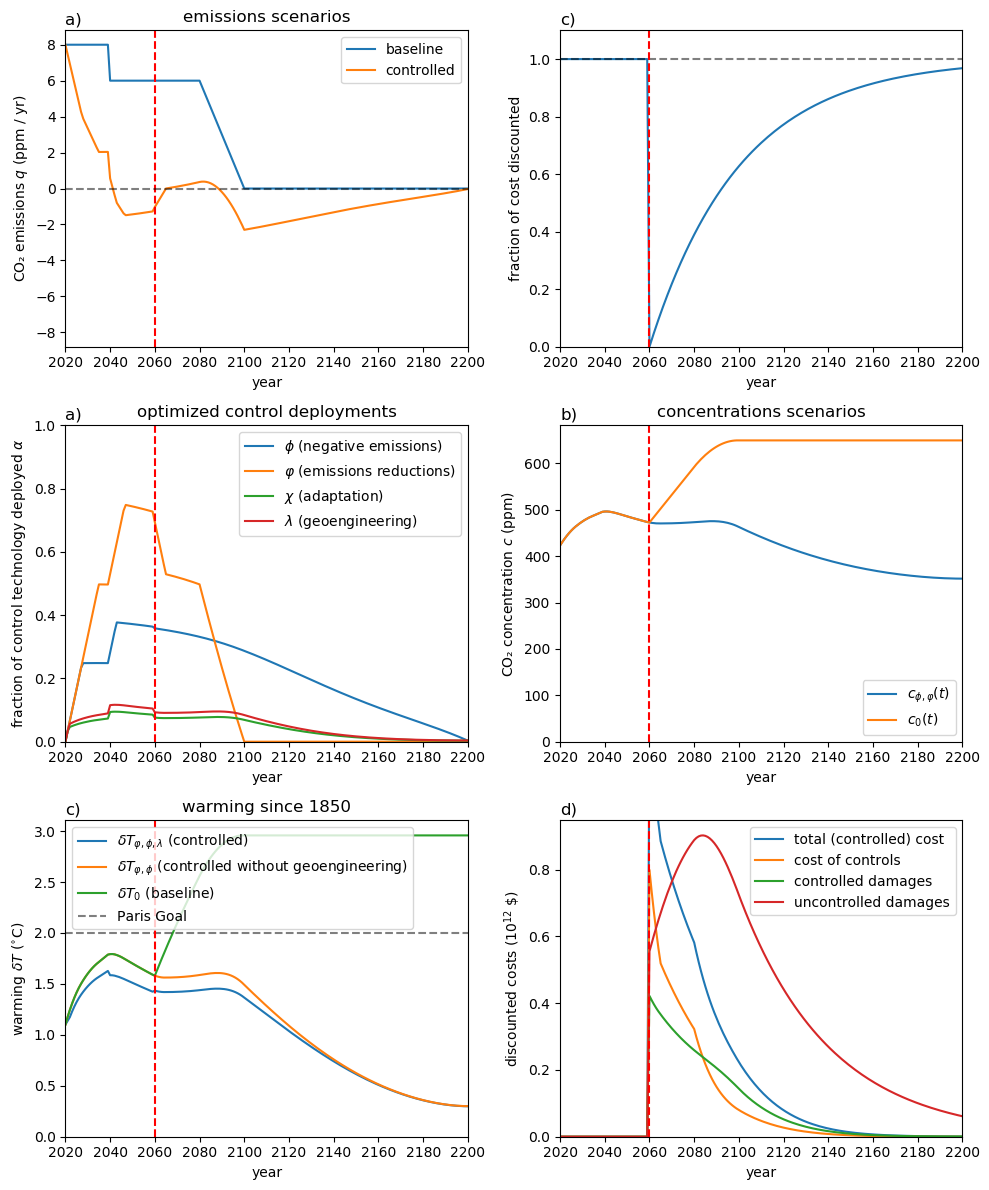

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2386
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1630

Total number of variables............................:     1465
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1284
                     variables with only upper bounds:        0
Total number of equality constraints.................:      901
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [31]:
model = step_forward(model, 20., 6., 2080., 20.)
optimize_controls!(model, maxslope = maxslope);
plot_state(model)
ensemble[model.name] = model;